In [23]:
#librerias
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")


# Carga y Preparación Datos

In [2]:
path='../data/raw/web.csv'
df_web=pd.read_csv(path)
df_web.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
0,202201,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
1,202202,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2,202203,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
3,202204,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
4,202205,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


**Información Columnas**



| Columna                        | Descripción procedencia                                      |
|-------------------------------|--------------------------------------------------------------------------------|
| `ID_Date`                     | Fecha usada para ordenar la serie temporal |
| `Unique_visitors`             | Número total de visitantes únicos a la web (variable objetivo)                |
| `PDFBrochuresDownloaded`      | Número de folletos PDF descargados por los usuarios    |
| `ProductConfigurator`         | Número de usos del configurador de producto en la web                         |
| `Product_configurator_Visists`| Número de visitas al configurador de producto                                 |
| `SocialNetworks`              | Tráfico desde redes sociales                                  |
| `DirectTraffic`               | Tráfico directo: usuarios que escriben la URL            |
| `EMail`                       | Tráfico desde campañas de correo electrónico                                  |
| `NaturalSearch`               | Tráfico orgánico desde buscadores como Google (SEO)                           |
| `OnlineMedia`                 | Tráfico desde medios online de pago  |
| `OtherReferrer`              |  Tráfico desde otras fuentes no categorizadas                                  |
| `PaidSearch`                  | Tráfico desde campañas de búsqueda pagada   |


## Transfomación de la Columna Date

Preparamos la columna `ID_Date` convirtiéndola en fechas mensuales, la usamos como índice temporal, ordenamos los datos y dejamos la serie lista para análisis mensual.


In [3]:
# Convertir ID_Date (tipo 202201) en una fecha real: 2022-01-01
df_web['Fecha'] = pd.to_datetime(df_web['ID_Date'].astype(str), format='%Y%m')

# Establecer Fecha como índice y ordenar
df_web.set_index('Fecha', inplace=True)
df_web.sort_index(inplace=True)

#Indicar que es una serie mensua
df_web = df_web.asfreq('MS')

# Para que no salga la hora
df_web.index = df_web.index.to_period('M')


In [4]:
df_web.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
Fecha,,,,,,,,,,,,
2022-01,202201,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
2022-02,202202,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2022-03,202203,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
2022-04,202204,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
2022-05,202205,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


# Serie Unique Visitors

A continuación, observamos cómo se comporta la variable objetivo `Unique_visitors`, que queremos predecir. Para ello, graficamos su evolución mensual en el tiempo:

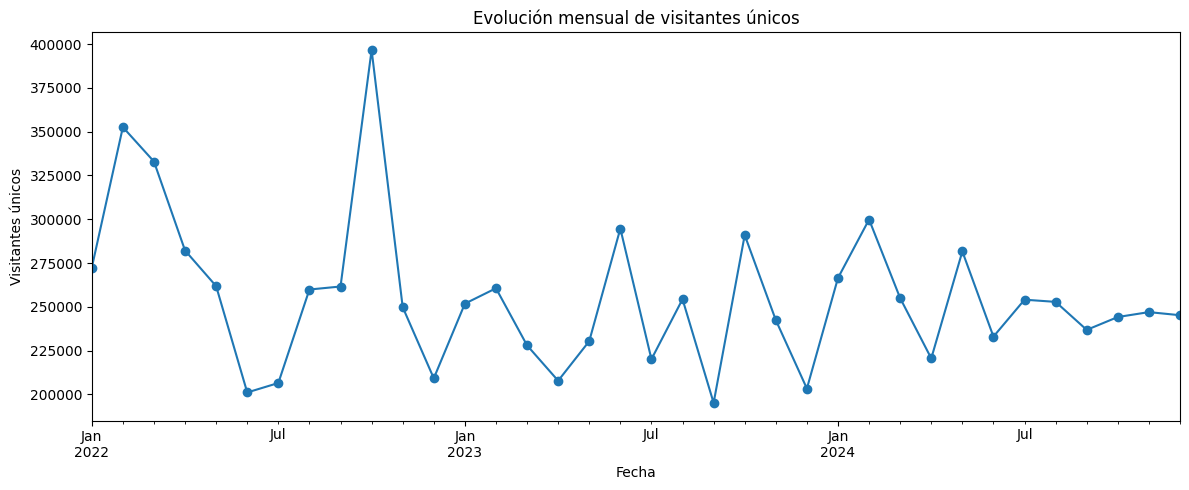

In [5]:
plt.figure(figsize=(12, 5))
df_web['Unique_visitors'].plot(marker='o', linestyle='-')
plt.title('Evolución mensual de visitantes únicos')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.tight_layout()
plt.show()


**Observaciones clave sobre la serie `Unique_visitors`**

- Picos de tráfico:
  - Se observan valores máximos especialmente en febrero de 2022 y septiembre de 2022.
  - También se registran aumentos destacados en enero de algunos años.

- Caídas pronunciadas:
  - El tráfico disminuye notablemente tras los picos.
  - En diciembre se detecta una caída recurrente del número de visitantes.

- **Estacionalidad**:
  - En enero suele haber una recuperación tras la bajada de diciembre.
  - Septiembre y octubre presentan subidas recurrentes que podrían asociarse a campañas o reinicio de actividad tras verano.

- **Tendencia general**:
  - A lo largo del periodo analizado, se observa una ligera tendencia descendente en el volumen de visitantes.
  - En los últimos meses, el comportamiento de la serie se muestra más estable.

## Descomposicón Serie

Se realiza la descomposición de la serie utilizando un modelo aditivo. Este tipo de modelo se aplica cuando se considera que la serie es el resultado de la suma de sus tres componentes principales:

- Serie original = Tendencia + Estacionalidad + Ruido

In [6]:
df_web.columns

Index(['ID_Date', 'Unique_visitors', 'PDFBrochuresDownloaded',
       'ProductConfigurator', 'Product_configurator_Visists', 'SocialNetworks',
       'DirectTraffic', 'EMail', 'NaturalSearch', 'OnlineMedia',
       'OtherReferrer', 'PaidSearch'],
      dtype='object')

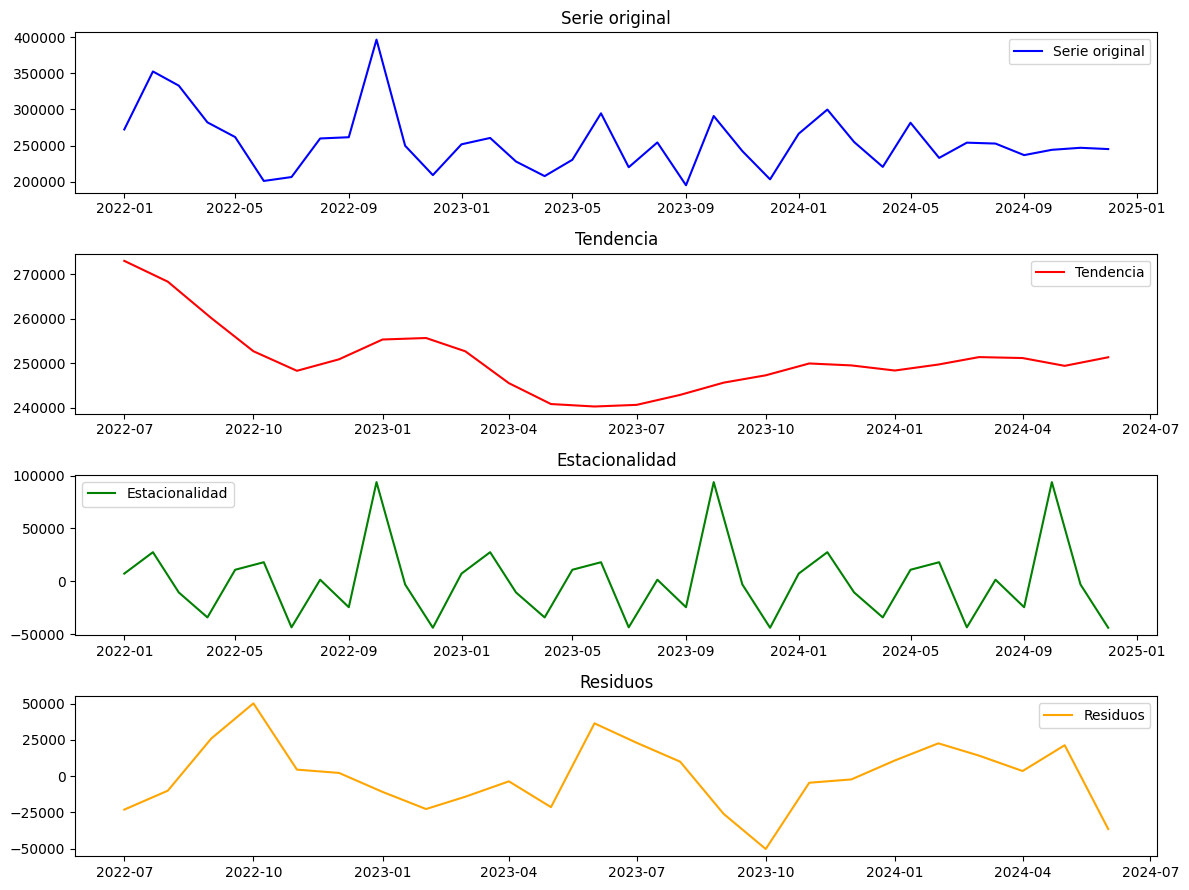

In [7]:
df_web.index = df_web.index.to_timestamp()
serie = df_web['Unique_visitors']

# Descomposición aditiva 
decomposition = seasonal_decompose(serie, model='additive', period=12) #periodo de 12 meses
# Tendencia/Estacionalidad
tendencia = decomposition.trend
estacionalidad = decomposition.seasonal
residuos = decomposition.resid

# Graficar la serie original y las tres componentes
plt.figure(figsize=(12, 9))

plt.subplot(411)
plt.plot(serie, label='Serie original', color='blue')
plt.title('Serie original')
plt.legend()

plt.subplot(412)
plt.plot(tendencia, label='Tendencia', color='red')
plt.title('Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(estacionalidad, label='Estacionalidad', color='green')
plt.title('Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(residuos, label='Residuos', color='orange')
plt.title('Residuos')
plt.legend()

plt.tight_layout()
plt.show()


**Descomposición Serie**

- Tendencia: Presenta una caída progresiva desde mediados de 2022 hasta mediados de 2023, seguida de una ligera recuperación y estabilización en 2024.

- Estacionalidad: Se detectan patrones que se repiten a lo largo del tiempo, con subidas y bajadas cíclicas, lo que confirma la presencia de estacionalidad anual.

- Residuos: No muestran una estructura clara, lo cual es positivo, ya que indica que la mayor parte de la variación ha sido explicada por la tendencia.

## Coeficientes Serie

**Justificación inicial de parámetros SARIMA**

- `d = 1` 
  Vemos claramente una tendencia descendente en la serie.  
  Para eliminarla, parte diferencial del modelo.

- `D = 1`, `s = 12`
  Observamos que se repiten los mismos patrones cada año, especialmente los picos en octubre y las caídas en enero.  
  Esto indica estacionalidad anual, así que usamos `D = 1` para eliminarla y `s = 12` porque trabajamos con datos mensuales.

- `q`, `Q` (componentes de errores) 
  Los residuos tienen ciertas oscilaciones, pero no es clara su estructura.  
  Por tanto, vamos a probar con distintos valores (`q = 0` o `1`, `Q = 0` o `1`) y elegir los que mejor se ajusten.

- `p`, `P` (componentes autoregresivos) 
  Aún no sabemos si los valores anteriores afectan directamente a los actuales.  
  Para decidirlo, vamos a usar los gráficos *ACF y PACF*, que nos dirán si existe esa relación.


## ACF Y PACF

¿Para qué sirven estos parámetros?

- **ACF**
  - Mide la correlación entre un valor y sus valores pasados.
  - Nos ayuda a elegir el parámetro `q` (parte MA = media móvil).

- **PACF**
  - Mide la correlación directa entre un valor y sus valores pasados, quitando los lags intermedios.
  - Nos ayuda a elegir el parámetro `p`(parte AR = autoregresiva).

**Gráfico ACF**

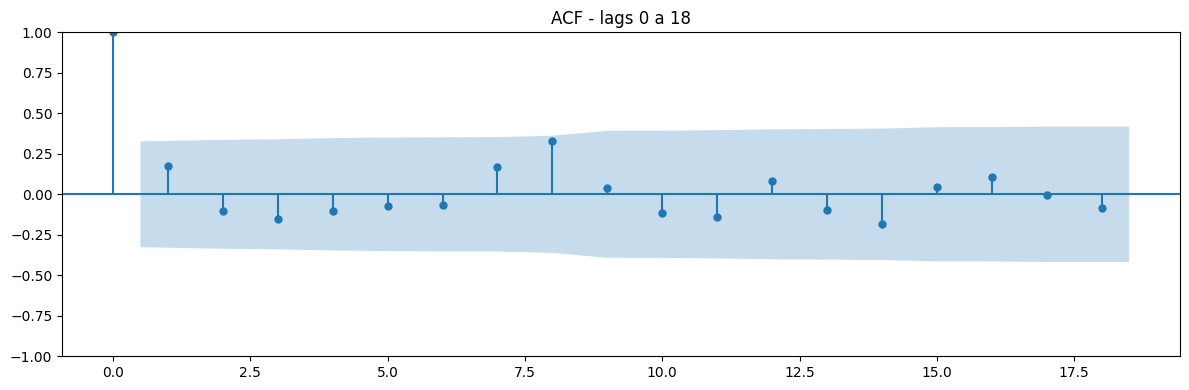

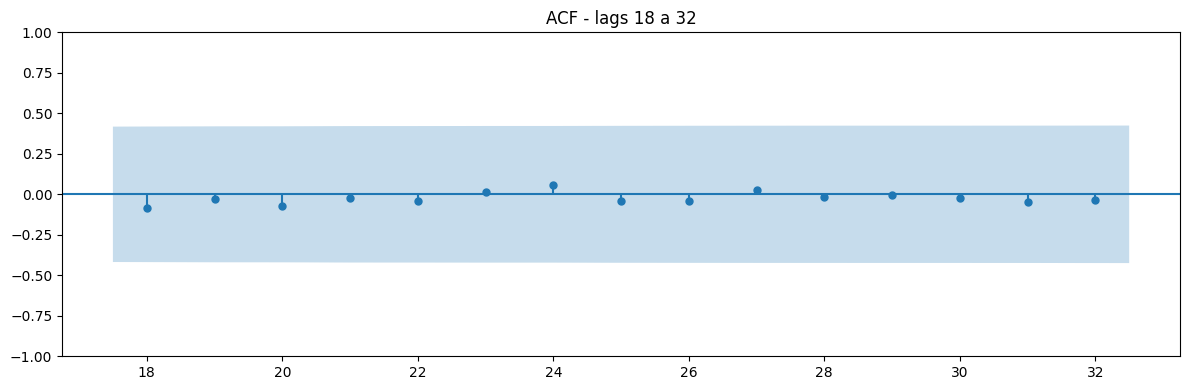

In [8]:
#Gráficos ACF (0-18 y 18-32)

fig, ax1 = plt.subplots(figsize=(12, 4))
plot_acf(serie, lags=18, ax=ax1)
ax1.set_title('ACF - lags 0 a 18')
plt.tight_layout()
plt.show()


fig, ax2 = plt.subplots(figsize=(12, 4))
plot_acf(serie, lags=range(18, 33), ax=ax2)
ax2.set_title('ACF - lags 18 a 32')
plt.tight_layout()
plt.show()

**Gráfico PACF**

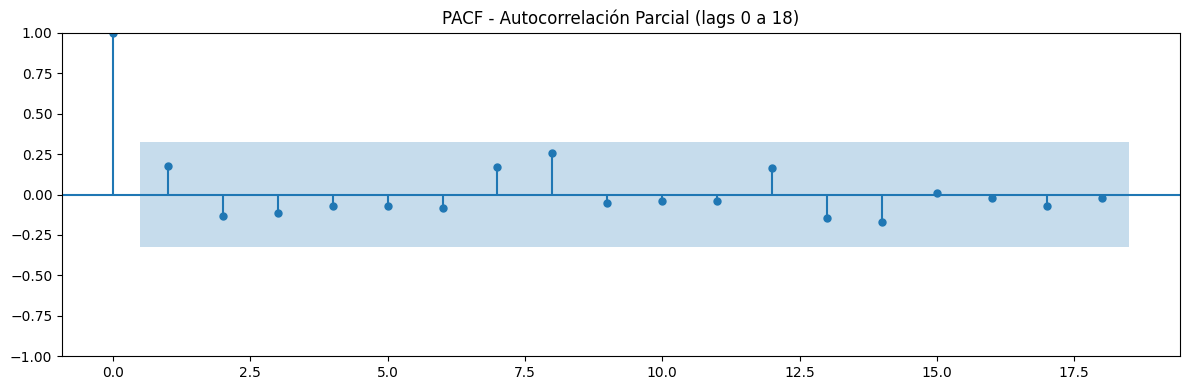

In [9]:
# PACF  (0 - 18)
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(serie, lags=18, ax=ax, method='ywm')
ax.set_title('PACF - Autocorrelación Parcial (lags 0 a 18)')
plt.tight_layout()
plt.show()

Párametros `p`y `q`

- *Parte autoregresiva (AR)* → `p = 8`  
  Porque el primer pico significativo de la PACF aparece en el **lag 8**, lo que sugiere una fuerte relación directa con el valor de hace 8 meses.

- *Parte de media móvil (MA)* → `q = 0` y `q = 1`  
  Vamos a probar ambos, ya que en el gráfico ACF no se observan muchos picos significativos. 

# Sarima

**División Train-Test**

In [18]:
# Serie temporal
serie_temporal = df_web['Unique_visitors']

# División 80/20
train_size = int(len(serie_temporal) * 0.8)
train = serie_temporal[:train_size]
test = serie_temporal[train_size:]

**Iteración Parámetros**

In [19]:
from pmdarima import auto_arima

modelo = auto_arima(train,
                   seasonal=True,
                   m=12,  
                   start_p=0,
                   start_q=0,
                   start_P=0,
                   start_Q=0,
                   d=1,
                   D=1,
                   max_p=3,
                   max_q=3,
                   max_P=2,
                   max_Q=2,
                   max_d=2,
                   max_D=1,
                   max_order=8,
                   stepwise=False,  # búsqueda exhaustiva
                   trace=True,
                   scoring='mae',
                   suppress_warnings=True)

print("Mejores hiperparámetros SARIMA:", modelo.get_params())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.300, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=367.872, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=369.479, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=368.040, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=369.858, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=371.430, Time=0.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=370.067, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=371.599, Time=0.07 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=373.181, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=373.877, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=371.145, Time=0.02 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=373.111, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=371.857, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=373.117, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=375.073, Time=0.19 sec
 ARIMA(0,1

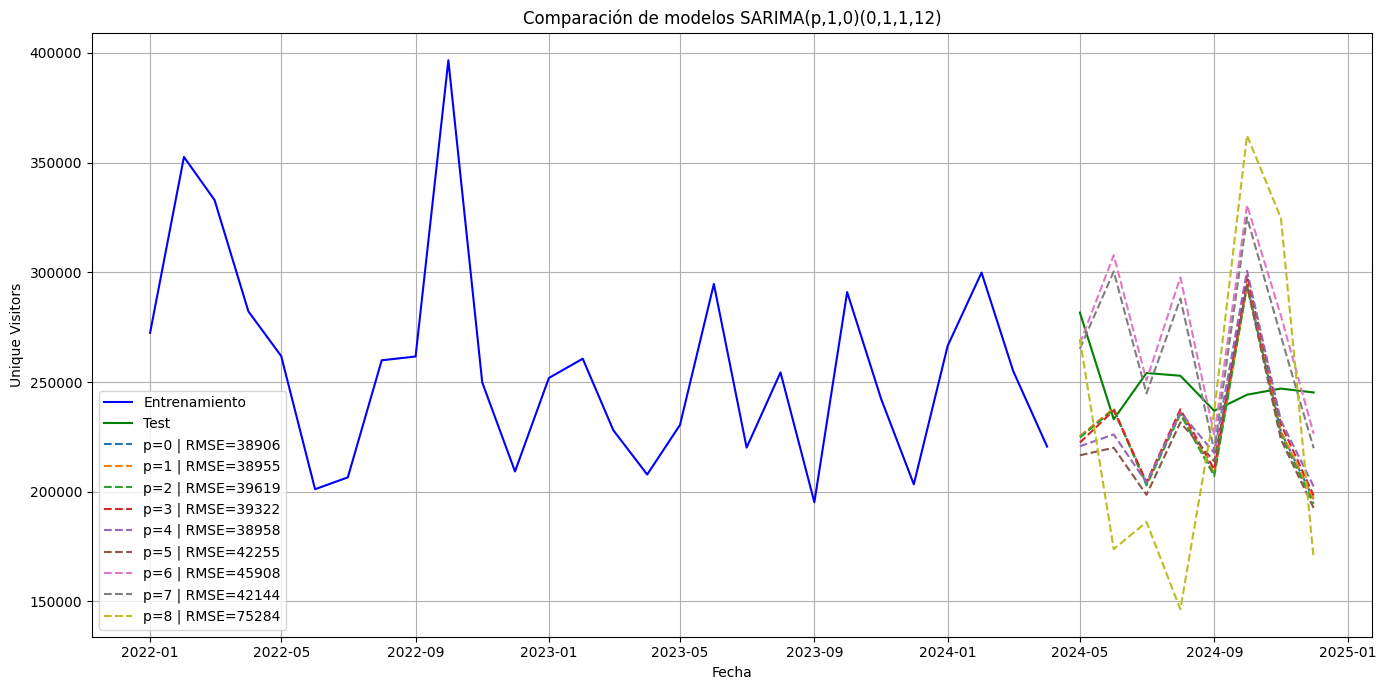


📊 Resultados ordenados por AIC:
 p     order          AIC          MAE         RMSE         R2
 0 (0, 1, 0) 3.678725e+02 34394.379175 38906.271672  -6.814321
 1 (1, 1, 0) 3.699958e+02 34466.633094 38955.081303  -6.833940
 4 (4, 1, 0) 3.722639e+02 33447.278716 38957.637183  -6.834968
 2 (2, 1, 0) 3.723971e+02 35172.166307 39619.124544  -7.103297
 7 (7, 1, 0) 3.732284e+02 34572.097396 42143.588005  -8.168853
 3 (3, 1, 0) 3.738122e+02 34064.069995 39321.698727  -6.982088
 5 (5, 1, 0) 3.752537e+02 37971.139247 42254.830589  -8.217321
 6 (6, 1, 0) 3.765961e+02 35832.759952 45907.720938  -9.879864
 8 (8, 1, 0) 1.710533e+06 64673.397622 75283.546590 -28.258505


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Crear estructura para guardar resultados
resultados_modelos = []

# Dibujar la serie real
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')

# Loop para probar p = 0 hasta 8
for p in range(9):
    try:
        model = SARIMAX(train, order=(p, 1, 0), seasonal_order=(0, 1, 1, 12))
        fit = model.fit(disp=False)
        pred = fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        mse, mae, rmse, r2 = calcular_metricas(test, pred)
        aic = fit.aic

        # Guardar resultados
        resultados_modelos.append({
            'p': p,
            'order': (p, 1, 0),
            'seasonal_order': (0, 1, 1, 12),
            'AIC': aic,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

        # Dibujar la predicción
        plt.plot(test.index, pred, linestyle='--', label=f'p={p} | RMSE={rmse:.0f}')
    except Exception as e:
        print(f"❌ Error en modelo SARIMA({p},1,0)(0,1,1,12): {e}")

# Gráfico final
plt.title('Comparación de modelos SARIMA(p,1,0)(0,1,1,12)')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resultados ordenados por AIC
df_resultados = pd.DataFrame(resultados_modelos).sort_values(by='AIC')
print("\n📊 Resultados ordenados por AIC:")
print(df_resultados[['p', 'order', 'AIC', 'MAE', 'RMSE', 'R2']].to_string(index=False))

**Mejor Modelo**

In [21]:
pred = modelo.predict(n_periods=len(test))

# 4. Calcular MAE
mae = mean_absolute_error(test, pred)

# 5. Mostrar resultados
print("\n Mejor modelo encontrado:")
print(" - Order:", modelo.order)
print(" - Seasonal Order:", modelo.seasonal_order)
print(" - AIC del mejor modelo:", modelo.aic())
print(" - MAE sobre test:", mae)


 Mejor modelo encontrado:
 - Order: (0, 1, 0)
 - Seasonal Order: (0, 1, 1, 12)
 - AIC del mejor modelo: 367.87248336250656
 - MAE sobre test: 34394.37917543624


In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Serie temporal
serie = df_web['Unique_visitors']

# División 80/20
train_size = int(len(serie) * 0.8)
train = serie[:train_size]
test = serie[train_size:]

# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Probar valores de p de 0 a 8
resultados = []

for p in range(9):  # p = 0 hasta 8
    try:
        modelo = SARIMAX(train, order=(p, 1, 0), seasonal_order=(0, 1, 1, 12))
        modelo_fit = modelo.fit(disp=False)
        pred = modelo_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        mse, mae, rmse, r2 = calcular_metricas(test, pred)

        resultados.append({
            'order': (p, 1, 0),
            'seasonal_order': (0, 1, 1, 12),
            'AIC': modelo_fit.aic,
            'MAE': mae,
            
            
        })
    except Exception as e:
        print(f"❌ Error con p={p}: {e}")

# Mostrar resultados ordenados por AIC
resultados_df = pd.DataFrame(resultados).sort_values(by='AIC')
print("\n Resultados ordenados por AIC:")
print(resultados_df)


 Resultados ordenados por AIC:
       order seasonal_order           AIC           MAE
0  (0, 1, 0)  (0, 1, 1, 12)  3.678725e+02  34394.379175
1  (1, 1, 0)  (0, 1, 1, 12)  3.699958e+02  34466.633094
4  (4, 1, 0)  (0, 1, 1, 12)  3.722639e+02  33447.278716
2  (2, 1, 0)  (0, 1, 1, 12)  3.723971e+02  35172.166307
7  (7, 1, 0)  (0, 1, 1, 12)  3.732284e+02  34572.097396
3  (3, 1, 0)  (0, 1, 1, 12)  3.738122e+02  34064.069995
5  (5, 1, 0)  (0, 1, 1, 12)  3.752537e+02  37971.139247
6  (6, 1, 0)  (0, 1, 1, 12)  3.765961e+02  35832.759952
8  (8, 1, 0)  (0, 1, 1, 12)  1.710533e+06  64673.397622


**p=4**

 Métricas del modelo SARIMA (4,1,0)(0,1,1,12):
MSE:  1,517,697,494.90
MAE:  33,447.28
RMSE: 38,957.64
R²:   -6.8350

 AIC del modelo: 372.26385779418615
 BIC del modelo: 376.5121590007994


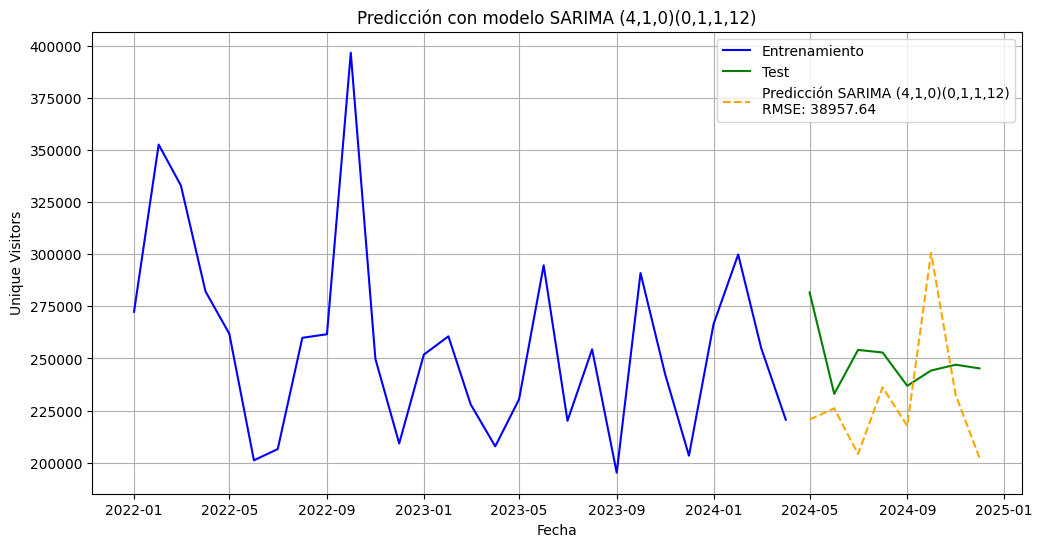

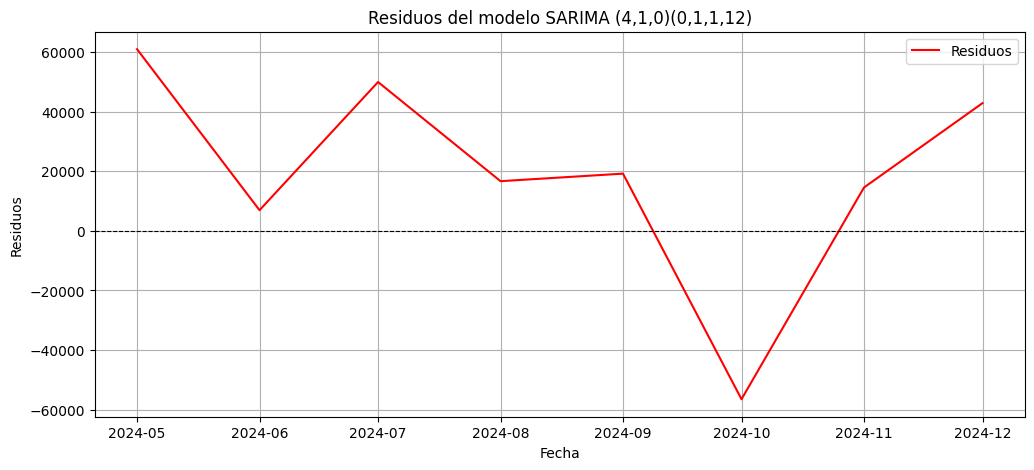

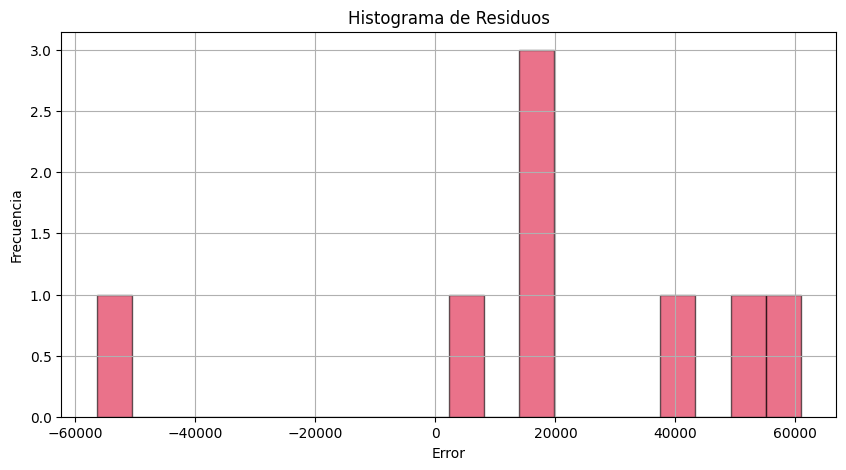


 Coeficientes del modelo SARIMA (4,1,0)(0,1,1,12):
                                      SARIMAX Results                                       
Dep. Variable:                      Unique_visitors   No. Observations:                   28
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -180.132
Date:                              Fri, 04 Apr 2025   AIC                            372.264
Time:                                      17:28:09   BIC                            376.512
Sample:                                  01-01-2022   HQIC                           372.219
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0032      0.276     -0.012   

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Supongamos que ya tienes la serie temporal separada:
# train, test = serie_temporal[:80%], serie_temporal[80:]

# Ajustar y predecir el modelo SARIMA (4,1,0)(0,1,1,12)
sarima_model = SARIMAX(train, order=(4, 1, 0), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metricas = calcular_metricas(test, sarima_predictions)
print(" Métricas del modelo SARIMA (4,1,0)(0,1,1,12):")
print(f"MSE:  {metricas[0]:,.2f}")
print(f"MAE:  {metricas[1]:,.2f}")
print(f"RMSE: {metricas[2]:,.2f}")
print(f"R²:   {metricas[3]:.4f}")

# AIC y BIC
print("\n AIC del modelo:", sarima_fit.aic)
print(" BIC del modelo:", sarima_fit.bic)

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, sarima_predictions, linestyle='--', label=f'Predicción SARIMA (4,1,0)(0,1,1,12)\nRMSE: {metricas[2]:.2f}', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.title('Predicción con modelo SARIMA (4,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Residuos
residuos = test - sarima_predictions

# Gráfico de residuos
plt.figure(figsize=(12, 5))
plt.plot(test.index, residuos, label='Residuos', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del modelo SARIMA (4,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=20, color='crimson', edgecolor='black', alpha=0.6)
plt.title('Histograma de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Coeficientes del modelo
print("\n Coeficientes del modelo SARIMA (4,1,0)(0,1,1,12):")
print(sarima_fit.summary())

**p=1**

 Métricas del modelo SARIMA (1,1,0)(0,1,1,12):
MSE:  1,517,498,359.30
MAE:  34,466.63
RMSE: 38,955.08
R²:   -6.8339

 AIC del modelo: 369.9957789819673
 BIC del modelo: 372.11992958527395


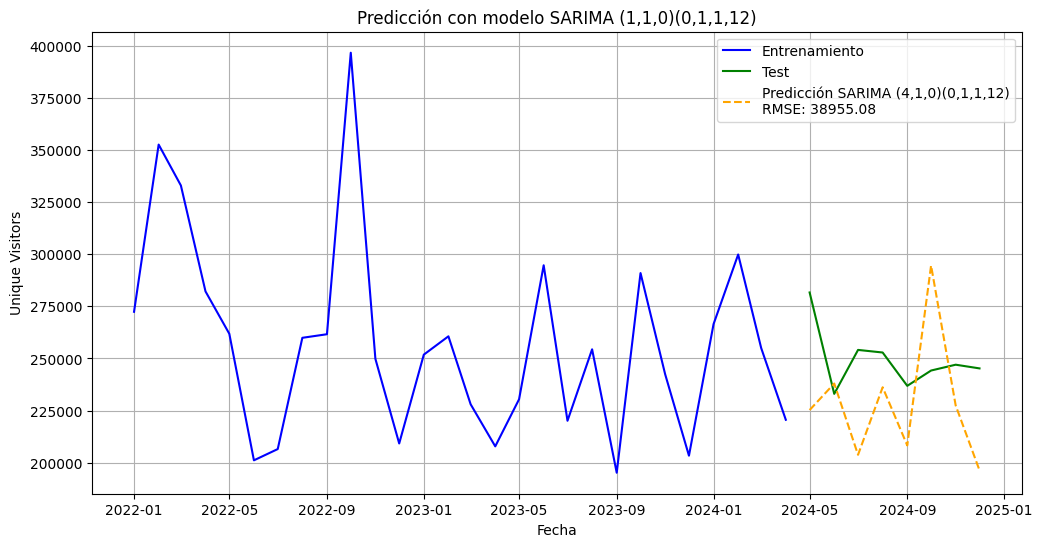

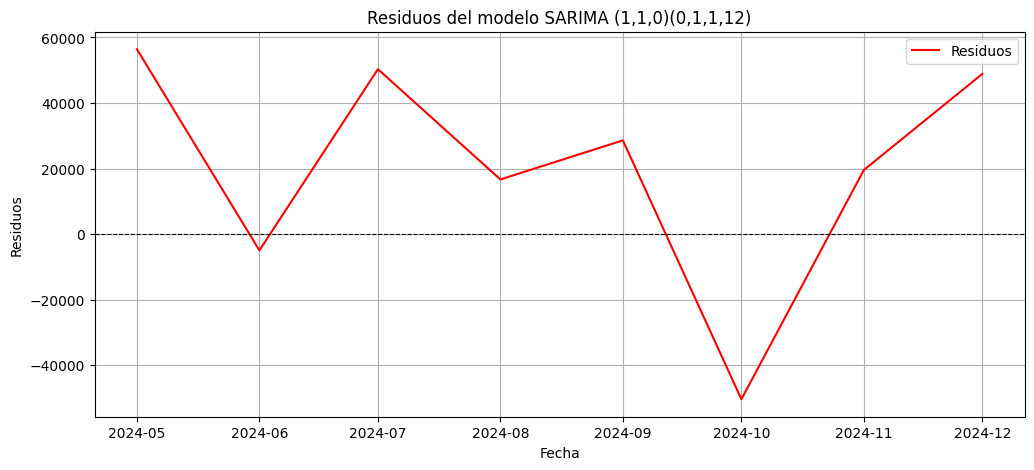

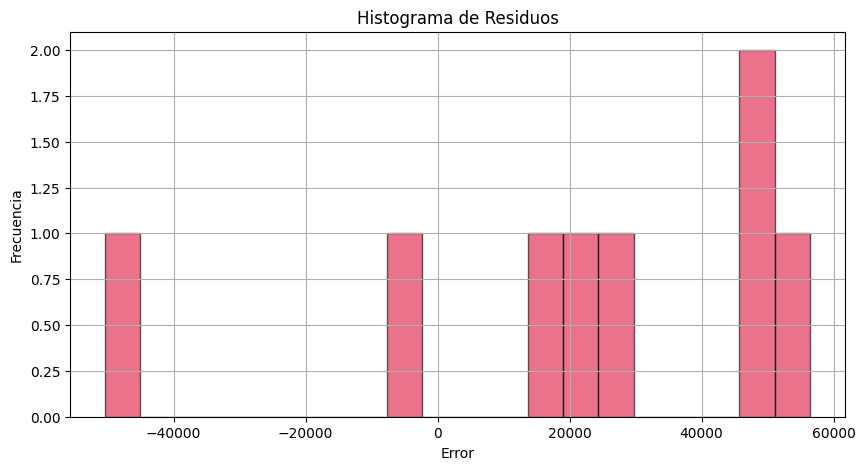


 Coeficientes del modelo SARIMA (1,1,0)(0,1,1,12):
                                      SARIMAX Results                                       
Dep. Variable:                      Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -181.998
Date:                              Fri, 04 Apr 2025   AIC                            369.996
Time:                                      17:27:49   BIC                            372.120
Sample:                                  01-01-2022   HQIC                           369.973
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0105      0.342      0.031   

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


sarima_model = SARIMAX(train, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metricas = calcular_metricas(test, sarima_predictions)
print(" Métricas del modelo SARIMA (1,1,0)(0,1,1,12):")
print(f"MSE:  {metricas[0]:,.2f}")
print(f"MAE:  {metricas[1]:,.2f}")
print(f"RMSE: {metricas[2]:,.2f}")
print(f"R²:   {metricas[3]:.4f}")

# AIC y BIC
print("\n AIC del modelo:", sarima_fit.aic)
print(" BIC del modelo:", sarima_fit.bic)

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, sarima_predictions, linestyle='--', label=f'Predicción SARIMA (4,1,0)(0,1,1,12)\nRMSE: {metricas[2]:.2f}', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.title('Predicción con modelo SARIMA (1,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Residuos
residuos = test - sarima_predictions

# Gráfico de residuos
plt.figure(figsize=(12, 5))
plt.plot(test.index, residuos, label='Residuos', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del modelo SARIMA (1,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=20, color='crimson', edgecolor='black', alpha=0.6)
plt.title('Histograma de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Coeficientes del modelo
print("\n Coeficientes del modelo SARIMA (1,1,0)(0,1,1,12):")
print(sarima_fit.summary())